## CIS 635 Project

### Leveraging Data Mining to Understand and Predict Airbnb Listing Prices

#### Loading required libraries

In [514]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

#### Downloading data from kaggle website

The data we are using for this project is hosted in kaggle. [U.S. Airbnb Open Data](https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data)

#### Downloading datasets in csv format

In [515]:
#Path to the dataset
path = kagglehub.dataset_download("kritikseth/us-airbnb-open-data")


In [516]:
#Connecting to files in path
csv_path1 = os.path.join(path, "AB_US_2020.csv")
csv_path2 = os.path.join(path, "AB_US_2023.csv")
#Load the data from CSV files
df1 = pd.read_csv(csv_path1)
df2 = pd.read_csv(csv_path2)
#Previewing the two datasets
print(df1.describe())
print(df2.describe())

C:\Users\obadi\AppData\Local\Temp\ipykernel_12296\798040142.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(csv_path1)


                 id       host_id       latitude      longitude  \
count  2.260300e+05  2.260300e+05  226030.000000  226030.000000   
mean   2.547176e+07  9.352385e+07      35.662829    -103.220662   
std    1.317814e+07  9.827422e+07       6.849855      26.222091   
min    1.090000e+02  2.300000e+01      18.920990    -159.714900   
25%    1.515890e+07  1.399275e+07      32.761783    -118.598115   
50%    2.590916e+07  5.138266e+07      37.261125     -97.817200   
75%    3.772624e+07  1.497179e+08      40.724038     -76.919323   
max    4.556085e+07  3.679176e+08      47.734620     -70.995950   

               price  minimum_nights  number_of_reviews  reviews_per_month  \
count  226030.000000    2.260300e+05      226030.000000       177428.00000   
mean      219.716529    4.525490e+02          34.506530            1.43145   
std       570.353609    2.103376e+05          63.602914            1.68321   
min         0.000000    1.000000e+00           0.000000            0.01000   
25%   

C:\Users\obadi\AppData\Local\Temp\ipykernel_12296\798040142.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(csv_path2)


In [517]:
#checking the length of columns in df1 and df2
print(f'Columns in df1 = {len(df1.columns)}')
print(f'Columns in df2 = {len(df2.columns)}')

Columns in df1 = 17
Columns in df2 = 18


In [518]:
#Selecting columns common in both df1 and df2 before concatenating the dataframes
df1_cols = set(df1.columns)
df2_cols = set(df2.columns)

#Common columns
common = df1_cols & df2_cols
unique_to_df2 = df2_cols - df1_cols
print("Common columns:", common)
print("Columns unique to df2:", unique_to_df2)

Common columns: {'longitude', 'minimum_nights', 'last_review', 'calculated_host_listings_count', 'id', 'host_name', 'host_id', 'room_type', 'city', 'name', 'neighbourhood_group', 'price', 'reviews_per_month', 'latitude', 'neighbourhood', 'availability_365', 'number_of_reviews'}
Columns unique to df2: {'number_of_reviews_ltm'}


In [519]:
# Finding unique columns in df1 (columns that are in df1 but not in df2)
unique_df1 = df1_cols - df2_cols
print("\nColumns unique to df1:", unique_df1)
# Finding unique columns in df2 (columns that are in df2 but not in df1)
unique_df2 = df2_cols - df1_cols
print("\nColumns unique to df2:", unique_df2)


Columns unique to df1: set()

Columns unique to df2: {'number_of_reviews_ltm'}


In [520]:
#selecting only common columns in df2 to merge df1.
df2 = df2[list(common)]
len(df2.columns)

17

In [521]:
#concatenating df1 and df2
joined_df = pd.concat([df1, df2], axis=0, ignore_index=True)
merged_df = joined_df.copy()

In [522]:
joined_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [523]:
joined_df.shape

(458177, 17)

The dataframe consists of 458177 entries and 17 variables.

In [524]:
#Checking the data types of various variables in the dataframe.
print(joined_df.info(show_counts=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458177 entries, 0 to 458176
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   id                              int64  
 1   name                            object 
 2   host_id                         int64  
 3   host_name                       object 
 4   neighbourhood_group             object 
 5   neighbourhood                   object 
 6   latitude                        float64
 7   longitude                       float64
 8   room_type                       object 
 9   price                           int64  
 10  minimum_nights                  int64  
 11  number_of_reviews               int64  
 12  last_review                     object 
 13  reviews_per_month               float64
 14  calculated_host_listings_count  int64  
 15  availability_365                int64  
 16  city                            object 
dtypes: float64(3), int64(7), obje

#### Checking the number of missing values for every column in joined df

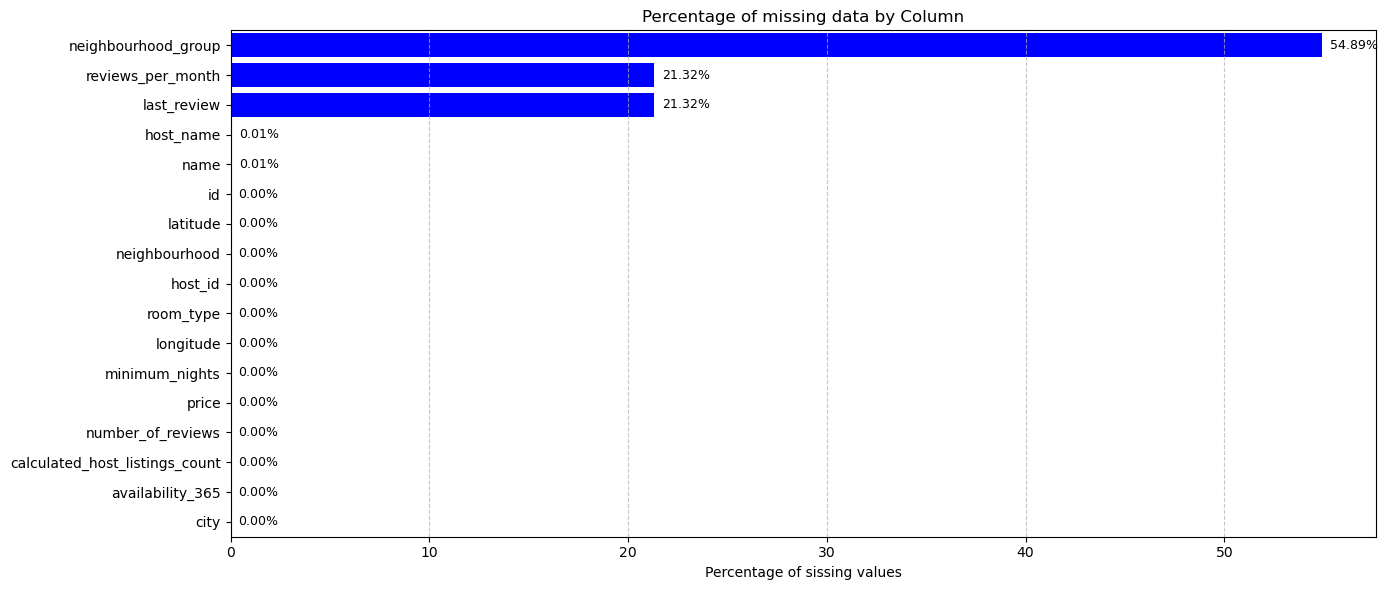

In [525]:
missing_counts = joined_df.isnull().sum()
missing_df = pd.DataFrame({'column': missing_counts.index, 
                           'missing_percent': (missing_counts.values/len(joined_df))*100
                           })
missing_df = missing_df.sort_values(by='missing_percent', ascending=False)
plt.figure(figsize=(14, 6))
bars = plt.barh(missing_df['column'], missing_df['missing_percent'], color='blue')
plt.ylim(-0.5, len(missing_df['column']) - 0.5)
plt.xlabel('Percentage of sissing values')
plt.title('Percentage of missing data by Column')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar, percent in zip(bars, missing_df['missing_percent']):
    plt.text(percent + 0.4, bar.get_y() + bar.get_height()/2,
             f'{percent:.2f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

Neighbourhood_group variable has the highest number of missing values at 54.89% of the total entries for neighbourhood_group. Reviews_per_month and last_review both have 21.32% of missing values. host_name and name have 0.01% of missing values which is negligible.

In [526]:
cleaned_df = joined_df.drop('neighbourhood_group', axis=1)
cleaned_df = cleaned_df.dropna()

Dropping missing values in reviews_per_month, last_review, host_name and name because they are negligible considering the size of our dataset.

Dropping neighbourhood_group because it has more than 50% of missing data which cannot be estimated or filled.

### Checking for noise in the dataframe

##### Checking for noise in price variable

In [527]:
#Removing values greater than 100,000 and less than 10 from price column
over_100000 = cleaned_df.index[(cleaned_df['price'] >= 62000) | (cleaned_df['price'] <=10)]
cleaned_df = cleaned_df.drop(over_100000)

count    360264.000000
mean        201.875958
std         430.278293
min          11.000000
25%          80.000000
50%         129.000000
75%         215.000000
max       58812.000000
Name: price, dtype: float64


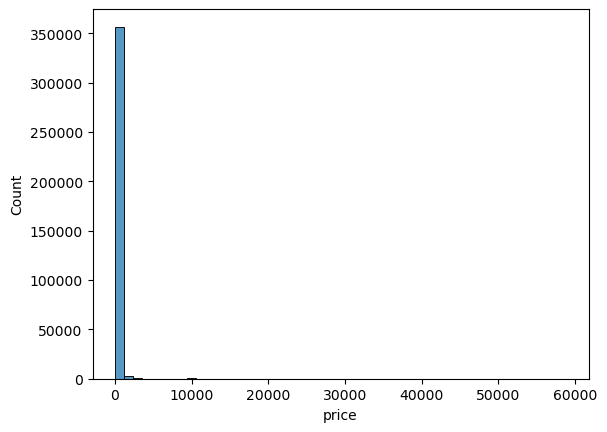

In [528]:
sns.histplot(cleaned_df['price'], bins=50, kde=False)
print(cleaned_df['price'].describe())

#### Checking for noise in minimum nights variable

In [529]:
above_limits = cleaned_df.index[(cleaned_df['minimum_nights'] >1) & (cleaned_df['minimum_nights'] <=365)]
cleaned_df = cleaned_df.loc[above_limits]

count    266116.000000
mean         12.902396
std          21.868501
min           2.000000
25%           2.000000
50%           3.000000
75%          30.000000
max         365.000000
Name: minimum_nights, dtype: float64


<Axes: xlabel='minimum_nights', ylabel='Count'>

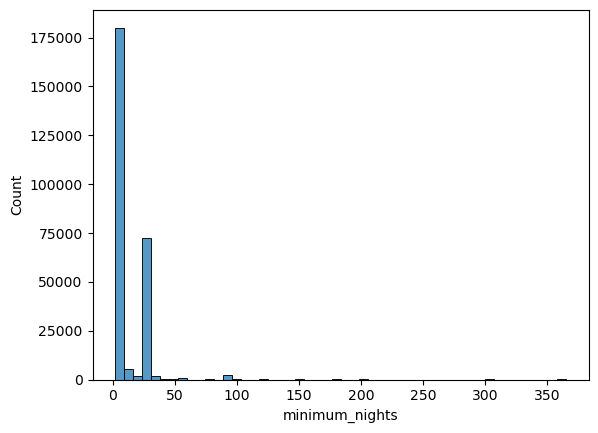

In [530]:
print(cleaned_df['minimum_nights'].describe())
sns.histplot(cleaned_df['minimum_nights'], bins=50, kde=False)

#### outlier detection

In [531]:
# Selecting columns containing outliers to compute their z-scores
cols_to_check = ['price', 'minimum_nights','availability_365','calculated_host_listings_count']
z_scores = np.abs(zscore(cleaned_df[cols_to_check]))

# Filtering rows where all selected columns have Z-score < 2
mask = (z_scores < 2).all(axis=1)
df_cleaned_1 = cleaned_df[mask]
df_cleaned_1.shape



(249883, 16)

<Axes: xlabel='minimum_nights'>

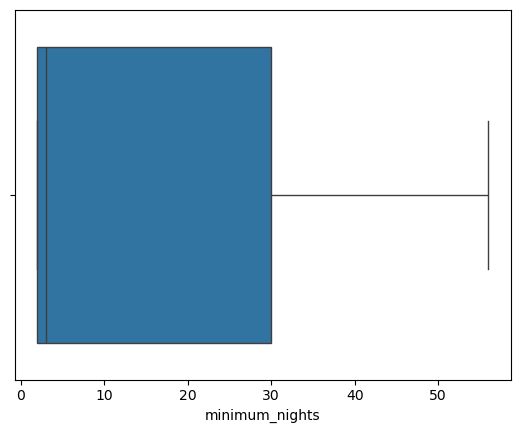

In [532]:
sns.boxplot(x=df_cleaned_1['minimum_nights'])

<Axes: xlabel='price'>

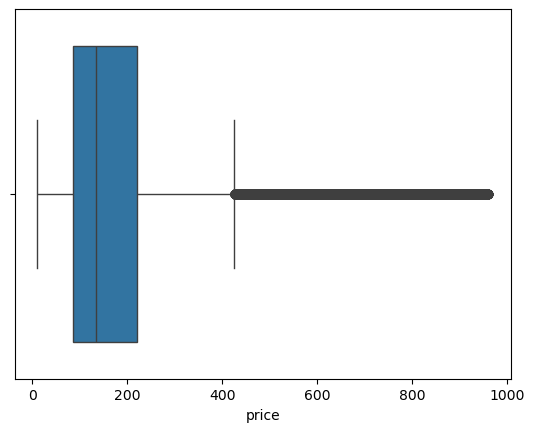

In [533]:
sns.boxplot(x=df_cleaned_1['price'])

<Axes: xlabel='availability_365'>

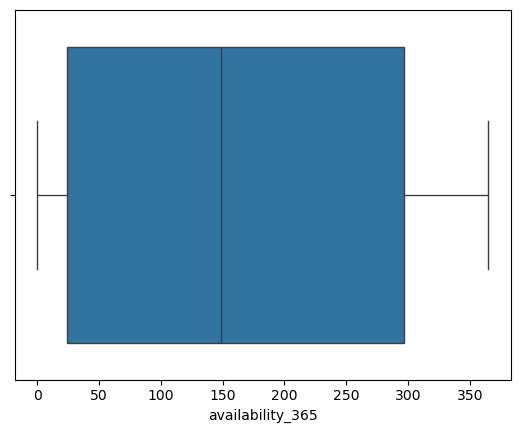

In [534]:
sns.boxplot(x=df_cleaned_1['availability_365'])

<Axes: xlabel='calculated_host_listings_count'>

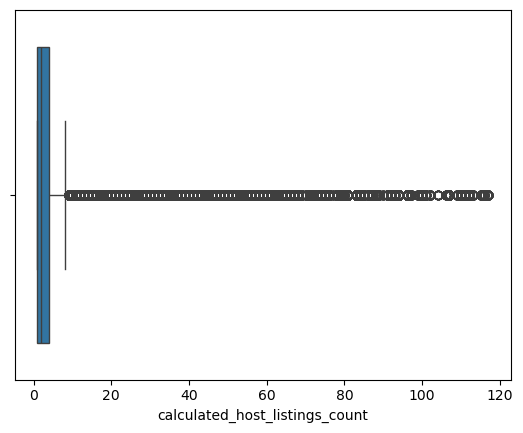

In [535]:
sns.boxplot(x=df_cleaned_1['calculated_host_listings_count'])

In [537]:
df_cleaned_1.shape

(249883, 16)